In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns
import math
import ast
import progressbar
import os

In [18]:
actors = pd.read_pickle("./data/actors.pkl")
movies = pd.read_pickle("./data/movies.pkl").set_index('IMDb_ID')

In [19]:
tmp = actors.droplevel(0, axis=1).merge(movies['averageRating'],left_on='IMDb_ID', right_index=True)

median_rating = tmp['averageRating'].median()

In [20]:
# Input:
#   - year (int)
#   - range (int)
# Output:
#   - Range (str)
def create_range(year, range=10):
    start_range = (year // range) * range
    return "{} - {}".format(start_range, start_range + range)


tmp = tmp.sort_values(by='Movie release date')
tmp['ReleaseYearRange'] = tmp['Movie release date'].apply(lambda x: create_range(x))

In [21]:
display(tmp)

,,,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName,birthYear,awards,nominations,movie_count,movie_count_genre,genres_b4,isMale,age_at_release,averageRating,ReleaseYearRange
,IMDb_ID,IMDb_actor_ID,,,,,,,,,,,,,,,
25699,tt0021338,nm0318624,1,28745159,School for Scandal,1930,Basil Gill,1877,0,0,1,0,1,1,53,4.8,1930 - 1940
13489,tt0020973,nm0310980,1,9252147,High Society Blues,1930,Janet Gaynor,1906,0,0,1,0,3,0,24,7.2,1930 - 1940
24855,tt0021069,nm0510018,1,6184646,The Life of the Party,1930,Winnie Lightner,1899,0,0,2,0,9,0,31,5.4,1930 - 1940
24856,tt0021360,nm0510018,1,10273670,She Couldn't Say No,1930,Winnie Lightner,1899,0,0,2,0,9,0,31,5.7,1930 - 1940
8169,tt0020642,nm0001256,1,8370506,Anna Christie,1930,Greta Garbo,1905,0,1,3,1,6,0,25,6.9,1930 - 1940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18094,tt2053339,nm0411692,1,35542027,Brave Hearts: Umizaru,2012,Hideaki Itô,1975,0,0,3,1,12,<NA>,37,6.5,2010 - 2020
18090,tt2008562,nm0688143,1,35571488,Le grand soir,2012,Benoît Poelvoorde,1964,0,0,1,0,1,1,48,5.9,2010 - 2020
27040,tt1852770,nm0470981,1,4097843,Dracula 3D,2012,Thomas Kretschmann,1962,0,0,2,0,5,1,50,3.6,2010 - 2020


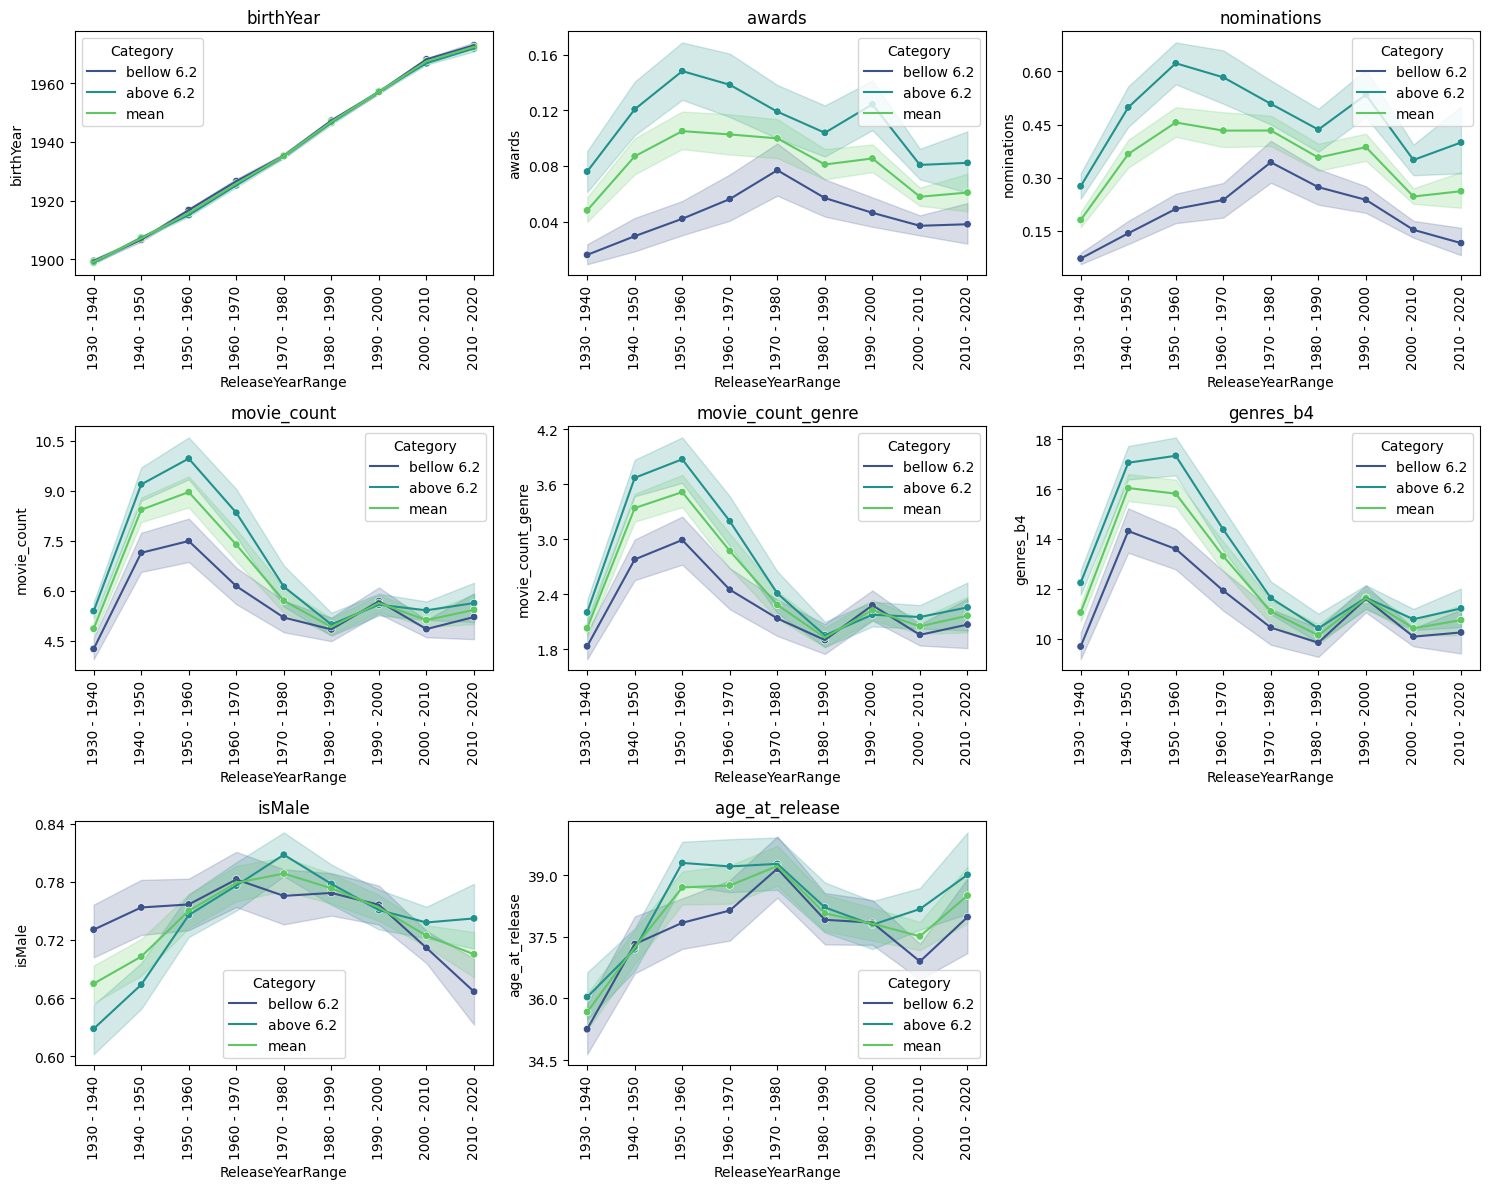

In [22]:
def do_fancy_ecpi_cute_plot(df, cat, diff, x, y_list, titles, ncols=3, max_y_ticks=5):

    nrows = -(-len(y_list) // ncols)  # Ceiling division to determine number of rows

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))

    df = df.replace("\\N", pd.NA)

    lo = df.query(f'{diff} < @{cat}').copy()
    hi = df.query(f'{diff} >= @{cat}').copy()
    me = df.copy()
    
    lo.loc[:, 'Category'] = 'bellow {}'.format(globals()[cat])
    hi.loc[:, 'Category'] = 'above {}'.format(globals()[cat])
    me.loc[:, 'Category'] = 'mean'

    for i, (y, title) in enumerate(zip(y_list, titles)):

        lo_filtered = lo[lo[y].notna()]
        hi_filtered = hi[hi[y].notna()]
        me_filtered = me[me[y].notna()]

        lo_filtered.loc[:, y] = pd.to_numeric(lo_filtered[y])
        hi_filtered.loc[:, y] = pd.to_numeric(hi_filtered[y])
        me_filtered.loc[:, y] = pd.to_numeric(me_filtered[y])
        
        lo_filtered_mean = lo_filtered.groupby(x)[y].mean().reset_index()
        lo_filtered_mean['Category'] = 'bellow {}'.format(globals()[cat])

        hi_filtered_mean = hi_filtered.groupby(x)[y].mean().reset_index()
        hi_filtered_mean['Category'] = 'above {}'.format(globals()[cat])

        me_filtered_mean = me_filtered.groupby(x)[y].mean().reset_index()
        me_filtered_mean['Category'] = 'mean'

        frame = pd.concat([lo_filtered, hi_filtered, me_filtered])
        frame_mean = pd.concat([lo_filtered_mean, hi_filtered_mean, me_filtered_mean])
    
        ax = axes[i // ncols, i % ncols]
        sns.lineplot(data=frame, x=x, y=y, hue='Category', errorbar='ci', palette='viridis', ax=ax)
        sns.scatterplot(data=frame_mean, x=x, y=y, hue='Category', palette='viridis', ax=ax, legend=False, marker='o', s=30)
        ax.set_title(title)
        ax.legend(title='Category')

        # Rotate x-axis labels
        for label in ax.get_xticklabels():
            label.set_rotation(90)

        # Set y-axis tick frequency
        ax.yaxis.set_major_locator(MaxNLocator(nbins=max_y_ticks))
    

    # Turn off any unused subplots
    for j in range(i + 1, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')

    plt.tight_layout()
    plt.show()

do_fancy_ecpi_cute_plot(tmp, 'median_rating', 'averageRating', 'ReleaseYearRange', 
                        ['birthYear', 'awards', 'nominations', 'movie_count', 'movie_count_genre', 'genres_b4', 'isMale', 'age_at_release'], 
                        ['birthYear', 'awards', 'nominations', 'movie_count', 'movie_count_genre', 'genres_b4', 'isMale', 'age_at_release'])